In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score

In [2]:
annotated_df = pd.read_csv('../data/softlabels_per_Subtype.csv', sep=',', index_col=0)
rnaseq_df = pd.read_csv('../data/Deconvo2.csv', sep=',', index_col=0).reset_index(names="Case ID")
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')

brca_df_filtered = annotated_df[
    (annotated_df['event.BRCA1'] != '1') &
    (annotated_df['event.BRCA2'] != 'Bi-allelic-undetermined') &
    (annotated_df['event.PALB2'] != '2')
]

# Identify common samples across the dataframes
common_samples = set(rnaseq_df['Case ID']).intersection(set(brca_df_filtered.index))

# Filter RNA-seq dataframe for common samples
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]

# Filter BRCA dataframe for common samples
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

rnaseq_df_common.set_index('Case ID', inplace=True)

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()


In [3]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

# genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)

In [4]:
# Drop columns that have only zeros
genes_validation_transposed = genes_validation_transposed.loc[:, ~(genes_validation_transposed == 0).all()]

# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]

In [5]:
deseq_results=pd.read_csv('../data/basic_deseq_HRD_contrast.csv', index_col=0)
deseq_filtered_rna_seq_df = rnaseq_df_common[rnaseq_df_common.columns.intersection(deseq_results.index)]

# Step 1: Find common columns
common_columns = set(deseq_filtered_rna_seq_df.columns).intersection(genes_validation_transposed.columns)

# Step 2: Filter each dataframe to keep only common columns
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df[list(common_columns)]
genes_validation_common = genes_validation_transposed_sorted[list(common_columns)]

# Display the resulting shapes to confirm
print("Shape of filtered deseq_filtered_rna_seq_df:", deseq_filtered_rna_seq_df_common.shape)
print("Shape of filtered genes_validation:", genes_validation_common.shape)

breast_filt = genes_validation_common[genes_validation_common.index.str.contains('BREAST')]

Shape of filtered deseq_filtered_rna_seq_df: (857, 6347)
Shape of filtered genes_validation: (1019, 6347)



Training Elastic Net to predict HRD probabilities:


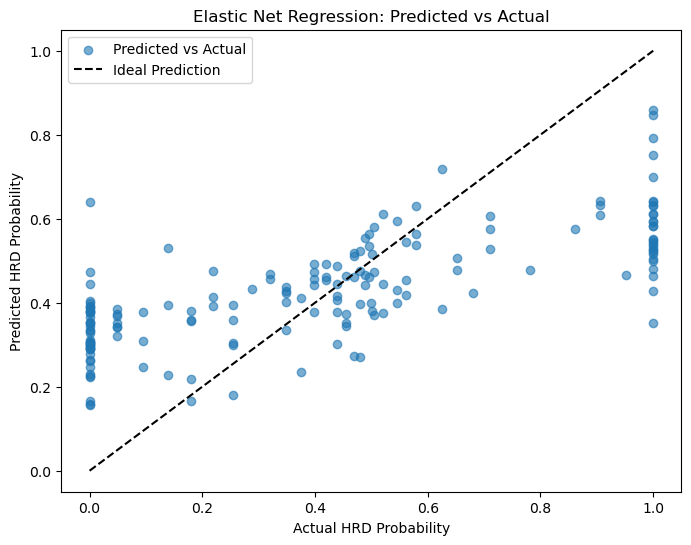


Results for Elastic Net Regression:
Mean Squared Error: 0.075
R^2 Score: 0.409


{'Mean Squared Error': 0.07488194730353981, 'R^2 Score': 0.4085667514645952}

In [6]:
# Data Preprocessing Function
def preprocess_data(X, y, task='regression'):
    """
    Preprocesses data by splitting into train-test sets and scaling features.
    For regression, no label encoding is applied.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Elastic Net Training & Evaluation
def train_evaluate_elastic_net_regression(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates an Elastic Net model for regression.
    Returns the trained model and evaluation metrics.
    """
    model = ElasticNet(alpha=0.25, l1_ratio=0.3, max_iter=1000, random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Scatter plot of predictions vs actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual HRD Probability')
    plt.ylabel('Predicted HRD Probability')
    plt.title('Elastic Net Regression: Predicted vs Actual')
    plt.legend(loc="upper left")
    plt.show()
    
    # Collect evaluation metrics
    metrics = {
        'Mean Squared Error': mse,
        'R^2 Score': r2
    }
    
    return model, metrics

# Main Execution
def main():
    """
    Main function for preprocessing data, training Elastic Net for regression, and displaying results.
    """
    print("\nTraining Elastic Net to predict HRD probabilities:")
    
    X_train, X_test, y_train, y_test = preprocess_data(
        # rnaseq_df_common.drop(columns=["Sample ID"]), brca_df_common['soft prob'], task='regression'
        deseq_filtered_rna_seq_df_common, brca_df_common['soft prob'], task='regression'
    )
    
    model, metrics = train_evaluate_elastic_net_regression(X_train, X_test, y_train, y_test)
    
    print("\nResults for Elastic Net Regression:")
    print(f"Mean Squared Error: {metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {metrics['R^2 Score']:.3f}")
    
    return model, metrics

# Execute Main
elastic_net_model, elastic_net_metrics = main()
elastic_net_metrics


In [7]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import ElasticNet
# X_train, X_test, y_train, y_test = preprocess_data(
#     deseq_filtered_rna_seq_df_common, brca_df_common['soft prob'], task='regression'
# )
# # Define parameter grid
# param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10],
#     'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
# }

# # Initialize ElasticNet model
# elastic_net = ElasticNet(max_iter=1000, random_state=42)

# # Perform Grid Search with Cross-Validation
# grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# # Best parameters and model
# best_model = grid_search.best_estimator_
# print("Best Parameters:", grid_search.best_params_)
# print("Best R^2 Score:", grid_search.best_score_)

# # Evaluate on test data
# y_pred = best_model.predict(X_test)
# print("Test R^2 Score:", r2_score(y_test, y_pred))


In [26]:
breast_filt_aligned

,PPP2R1B,DPH1,RASSF7,UNG,IRX5,AGO2,VPS37B,KDM6B,OCIAD2,SYT17,...,SLC6A9,MGAT4B,APPL1,ITPK1,SEMA4C,LRP2,OSTC,RABGGTB,C8orf82,ACTR3B
AU565_BREAST,13.264589,12.172428,12.940314,13.376261,10.824163,10.691744,11.829326,12.995767,11.009829,12.649256,...,11.722808,13.924534,13.537582,14.745884,13.402479,5.247928,13.669328,14.178276,11.561288,10.437752
BT20_BREAST,13.127672,11.816184,13.679590,13.730682,9.361944,13.552549,13.261654,13.330357,12.316847,11.928888,...,11.184875,15.124606,13.404609,14.588480,13.296343,9.055282,13.201664,13.218715,11.544964,10.624795
BT474_BREAST,12.764457,11.957828,11.546412,13.653965,11.952013,11.861087,13.424560,12.771077,12.327272,11.262682,...,10.857981,13.812378,12.633903,15.070456,12.733863,12.796851,12.665114,13.060865,11.979068,11.446049
BT483_BREAST,12.268834,11.470659,13.702822,13.674082,12.950920,13.180842,12.924813,13.296916,12.511258,12.641149,...,10.829723,14.454621,12.851944,13.466459,13.905199,12.029977,12.832297,12.332876,12.358926,11.483816
BT549_BREAST,13.534546,12.239002,10.930737,13.579787,11.369052,12.857981,12.437232,12.492104,10.539159,9.888743,...,13.246741,15.266933,13.429538,12.902375,12.346514,4.321928,13.985842,14.480727,12.329796,11.396605
CAL120_BREAST,13.532234,10.926296,11.430453,12.596423,5.857981,11.099348,11.705200,11.786270,12.985486,8.139551,...,10.882643,14.437817,13.082981,12.431759,11.839597,5.754888,13.767253,13.789839,10.370687,10.485829
CAL148_BREAST,13.733227,13.081816,13.874405,14.854917,13.531747,12.929628,14.781206,15.012101,13.651164,13.187507,...,10.178665,15.353560,13.679260,15.592282,13.797155,7.870365,13.620564,12.627306,12.261801,12.565816
CAL51_BREAST,12.755305,11.356452,11.977280,13.426789,10.178665,11.905387,11.766529,12.408595,12.183015,9.696968,...,10.827343,13.949553,13.327974,13.739570,12.979247,4.247928,13.656537,12.773139,10.565102,11.074141
CAL851_BREAST,13.242876,11.377211,12.333155,13.828434,5.459432,12.284535,13.042001,11.900489,13.428360,6.087463,...,12.749450,14.530040,12.832494,13.234368,12.968127,2.807355,13.446696,13.166791,10.537218,10.730470
CAMA1_BREAST,12.570093,11.908017,13.180531,14.458919,14.496167,13.181929,11.664892,12.547377,13.271609,12.304637,...,11.959278,15.014587,13.301067,14.507175,13.207472,13.837529,13.779719,13.025659,13.142426,11.303210


In [9]:
breast_filt = breast_filt.clip(lower=1e-6)

# Apply log2 transformation
breast_filt = np.log2(breast_filt)

In [10]:
# Align breast_filt with deseq_filtered_rna_seq_df_common columns
breast_filt_aligned = breast_filt.reindex(columns=deseq_filtered_rna_seq_df_common.columns, fill_value=0)

# Check for column alignment
print("Are columns aligned?", list(breast_filt_aligned.columns) == list(deseq_filtered_rna_seq_df_common.columns))

# Use breast_filt_aligned for predictions
predictions = elastic_net_model.predict(breast_filt_aligned)
# breast_filt['predictions'] = predictions.clip(0, 1)  # Clip predictions to [0, 1]


Are columns aligned? True


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [11]:
predictions

array([0.82161229, 0.49760806, 0.59507497, 0.419157  , 0.72412595,
       0.55785545, 0.611852  , 0.52062289, 0.66093464, 0.53413415,
       0.63618074, 0.56042539, 0.32913513, 0.65517129, 0.69032539,
       0.67560362, 0.60698179, 0.51416878, 0.51159452, 0.71119404,
       0.77015812, 0.64144304, 0.60687927, 0.74542439, 0.64113944,
       0.72142458, 0.4863017 , 0.76794722, 0.72190556, 0.46062577,
       0.78126748, 0.47523762, 0.7913411 , 0.71527505, 0.53841515,
       0.53690805, 0.27935199, 0.73409196, 0.39996144, 0.44881914,
       0.64974118, 0.57092385, 0.84832756, 0.7880097 , 0.6784658 ,
       0.71872293, 0.32486545, 0.43679467, 0.72178052, 0.50811866,
       0.5147648 ])

In [12]:
breast_filt.index = breast_filt.index.str.split('_').str[0]

In [24]:
import pandas as pd
import numpy as np

# Load the data
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 18 23_56_13 2025.csv')

# Define PARP inhibitors
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']

# Filter and select specific drugs
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']].copy()

# Apply transformations explicitly
parpi_resp_filt['IC50'] = parpi_resp_filt['IC50'].clip(lower=1e-6)
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])
parpi_resp_filt



,Drug Name,Cell Line Name,IC50,log10IC50
0,Olaparib,HCC1954,4.017502,0.603956
1,Olaparib,HCC1143,5.307956,0.724927
2,Olaparib,HCC1187,4.459187,0.649256
3,Olaparib,HCC1395,3.496354,0.543615
4,Olaparib,HCC1599,4.608563,0.663565
...,...,...,...,...
384,Talazoparib,HDQ-P1,3.718242,0.570338
385,Talazoparib,JIMT-1,4.466165,0.649935
386,Talazoparib,HCC1500,5.377461,0.730577
387,Talazoparib,YMB-1-E,2.975015,0.473489


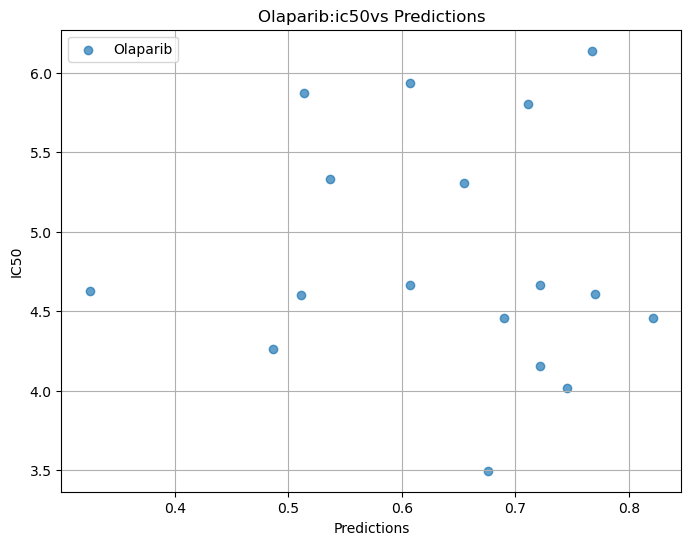

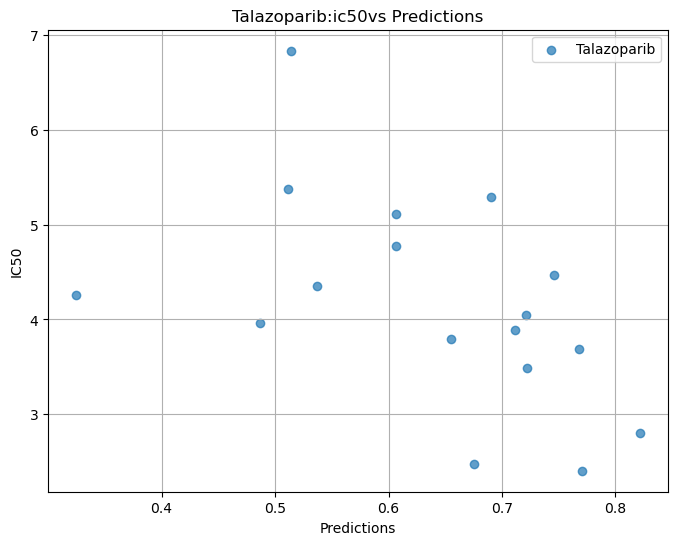

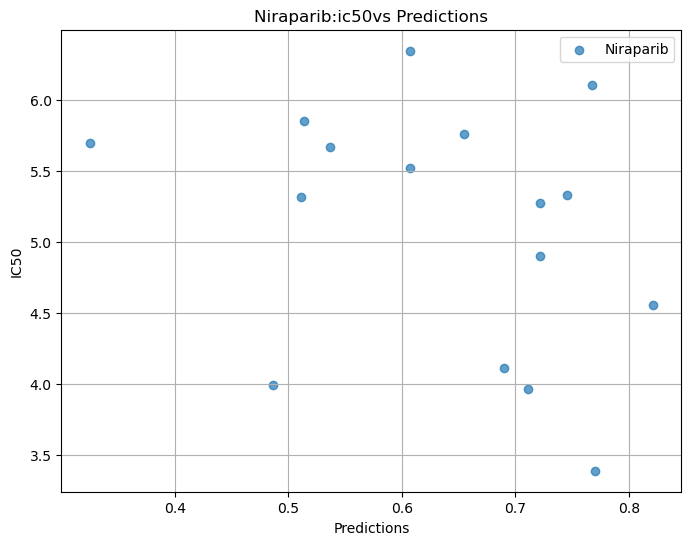

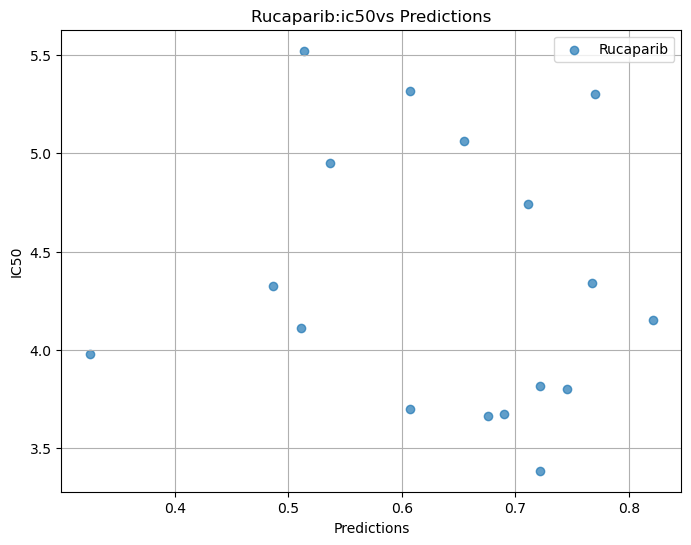

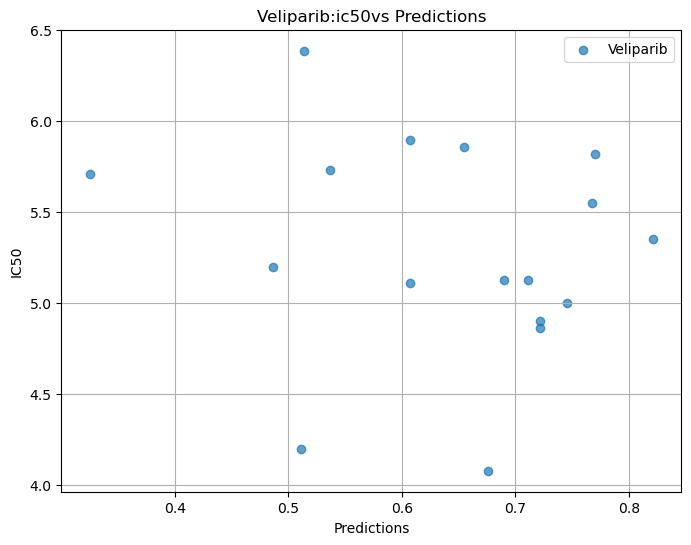

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums
import matplotlib.pyplot as plt

# Removing suffix '_BREAST' from breast_filt_aligned's index
breast_filt_aligned.index = breast_filt_aligned.index.str.replace('_BREAST', '')

# Matching indices of breast_filt_aligned to parpi_resp_filt['Cell Line Name']
matched_parpi = parpi_resp_filt[parpi_resp_filt['Cell Line Name'].isin(breast_filt_aligned.index)].copy()

# Ensuring alignment
matched_parpi = matched_parpi.set_index('Cell Line Name')
matched_parpi = matched_parpi.loc[breast_filt_aligned.index.intersection(matched_parpi.index)]

# Adding predictions to matched_parpi
# Convert predictions array into a Series with the same index as breast_filt_aligned
predictions_series = pd.Series(predictions, index=breast_filt_aligned.index)

# Add predictions to matched_parpi by aligning indices
matched_parpi['Predictions'] = matched_parpi.index.map(predictions_series)

# matched_parpi['Predictions'] = predictions[matched_parpi.index]

# Perform Wilcox test and plot for each drug
ic50 = "IC50"
results = []
for drug in parps:
    drug_data = matched_parpi[matched_parpi['Drug Name'] == drug]
    if len(drug_data) > 0:
        # Wilcox test
        statistic, p_value = ranksums(drug_data[ic50], drug_data['Predictions'])
        results.append({'Drug Name': drug, 'Wilcox Statistic': statistic, 'P-Value': p_value})
        
        # Plotting
        plt.figure(figsize=(8, 6))
        plt.scatter(drug_data['Predictions'],drug_data[ic50], alpha=0.7, label=f'{drug}')
        plt.title(f'{drug}:ic50vs Predictions')
        plt.ylabel(ic50)
        plt.xlabel('Predictions')
        plt.legend()
        plt.grid(True)
        plt.show()

# Creating a DataFrame to display Wilcox test results
wilcox_results_df = pd.DataFrame(results)



In [29]:
wilcox_results_df

,Drug Name,Wilcox Statistic,P-Value
0,Olaparib,0.706092,0.480131
1,Talazoparib,-0.981641,0.326277
2,Niraparib,1.507557,0.131668
3,Rucaparib,-0.499431,0.617476
4,Veliparib,1.877172,0.060494
